In [1]:
import pandas as pd

In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords 

from sklearn.metrics import f1_score, make_scorer
import numpy as np

# отключение предупреждений
import warnings; warnings.filterwarnings("ignore", category=Warning)

In [3]:
from collections import Counter
import re
import pymorphy2

In [4]:
import nltk
#nltk.download('stopwords')

In [5]:
from nltk import word_tokenize
import nltk
#nltk.download('punkt')

In [6]:
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
#from catboost import CatBoostClassifie

# грузим сет

In [ ]:
# исходный сет 
# train = pd.read_parquet('data_fusion_train.parquet')

# удаляем лишнее

In [ ]:
#train = train.drop(['receipt_id', 'receipt_dayofweek', 'receipt_time','brands'], axis='columns')

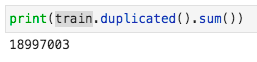

из 26 млн - 18.9 полные дубликаты по item_quantity - item_price - item_nds_rate - category_id

In [ ]:
# train_no_dublic= train.drop_duplicates().reset_index(drop=True)

In [ ]:
# train_no_dublic.to_parquet('data_fusion_train_no_dubl')

In [ ]:
# train_no_dublic.item_name = train_no_dublic.item_name.str.lower()

In [ ]:
# print(train_no_dublic.duplicated().sum())
# было порядка 34 тыс после перевода в нижний

In [ ]:
# train_no_dublic_low= train_no_dublic.drop_duplicates().reset_index(drop=True)

In [ ]:
# train_no_dublic_low.to_parquet('data_fusion_train_no_dubl_low')

## грузим сет - без дубликатов и в нижнем регистре

In [ ]:
# сет для анализа 
#train = pd.read_parquet('data_fusion_train_no_dubl_low')

## удаляем символы ненужные

In [ ]:
# удаляем ненужные знаки

# remove = [",", ".", "*", '"', "№", ")", "(", "%", '/', '+','-','#',':',';','@','$','^','&','=']
# train['item_name_clean'] = train['item_name'].str.replace(r"[{}]+".format(" ".join([re.escape(x) for x in remove]))," ", regex=True)

In [ ]:
# удаляем цифры

# train['item_name_clean'] = train['item_name_clean'].apply(
#     lambda x:''.join(ch for ch in x if ch.isalpha() or ch.isspace())
# )

In [ ]:
# проверяем наличие дубликатов

#print(train.duplicated().sum())
# нет дубликатов

In [ ]:
# сохраняем сет без цифр и знаков препинаний и спец знаков

#train.to_parquet('data_fusion_train_no_dubl_low_wo_simb')

## tokenizing

In [ ]:
# train = pd.read_parquet('data_fusion_train_no_dubl_low_wo_simb')

In [ ]:
# %%time
# train['item_name_token'] = train.apply(lambda x: nltk.word_tokenize(x['item_name_clean']), axis=1)

In [ ]:
#train.to_parquet('data_fusion_train_no_dubl_low_wo_simb_token')

In [ ]:
#train = pd.read_parquet('data_fusion_train_no_dubl_low_wo_simb_token')

## отбор слов фикс длины - новый столбец 

In [65]:
def words(text, min_len):
    text = [w for w in text if len(w) >= min_len]
        
    return ' '.join(text)

## класс 71 формируем словарь

In [ ]:
# class_71 = train.query('category_id == 71')

In [ ]:
# сохняем сет для класса 71

# class_71.to_parquet('train_71')

In [ ]:
#class_71 = pd.read_parquet('train_71')

In [ ]:
# выбираем слова заданной длины - через функцию words
#class_71['items'] = class_71['item_name_token'].apply(func=lambda x : words(x, 4))

In [ ]:
# заполняем пробелы между словами на "_"
# наверное это уже можно и не делать - так как используется строгое обращение - .isin()
# remove = [" "]
# class_71['items_'] = class_71['items'].str.replace(r"[{}]+".format("".join([re.escape(x) for x in remove])),"_", regex=True)

In [ ]:
# получаем словарь для cat 71 состоящий из слов >= 4 буквы
# common = pd.Series(class_71['items_'].value_counts().sort_values(ascending = False)).reset_index().query('index != ""')
# print(len(common))

In [ ]:
# убираем слова встречающиеся лишь 1 раз (возможно это неправильно), цель сокращения словаря - сократить время фильтрации неразмеченного train
# common = common.query('items_ > 1')
# common

In [180]:
             # проверка  - не удалять
dict_71.loc[dict_71.loc[:, 'index'] == 'пакет']

,index,items_


In [ ]:
# сохраняем словарь для класса 71
# common.to_parquet('dict_71')

In [179]:
dict_71 = pd.read_parquet('dict_71')

In [ ]:
#class_71 = pd.read_parquet('train_71')

In [ ]:
            # НЕ УДАЛЯТЬ
# работающий пример - поиск по слову
# dict_temp = ['салат_сельдь_под_шубой']
# WWW = class_71[class_71['items_'].str.contains('|'.join(dict_temp))]
# WWW

In [ ]:
# из DataFrame в список
# dict_71 = (dict_71['index'].to_list())

**словарь для класса 71 - готов**

## подготовка неразмеченной выборки

**подготовим генеральныю выборку - применим ограничение по длине слова**
изначально использовал длинные слова - 5+, но после использования _ решил сократить ограничение до 4-х, так как теряются важные детали

In [ ]:
# грузим трейн основной
# train = pd.read_parquet('data_fusion_train_no_dubl_low_wo_simb_token')

In [ ]:
%%time

# разбиваем токенизированный набор на отдельные слова
train['item_name_4_letters'] = train['item_name_token'].apply(func=lambda x : words(x, 4))

In [ ]:
%%time
# заполняем пробелы между словами на "_"
remove = [" "]
train['items_'] = train['item_name_4_letters'].str.replace(r"[{}]+".format("".join([re.escape(x) for x in remove])),"_", regex=True)

In [ ]:
%%time
# так как разметка делается по **item_name** и **items_** убираем ненужные столбцы
train_short = train.drop(['item_quantity', 'item_price', 'item_nds_rate', 'item_name_clean', 'item_name_token', 'item_name_4_letters'], axis='columns')

In [ ]:
# сохраняем неразмеченную обрезанную выборку
train_short.to_parquet('train_short')

## выбираем признаки относящиеся к классу № 71

In [ ]:
train_short = pd.read_parquet('train_short')

In [ ]:
%%time
train_short['cat_71'] = train_short['items_'].isin(dict_71)

In [ ]:
train_short["cat_71"] = train_short["cat_71"].astype(int)

In [ ]:
train_short.loc[train_short['cat_71'] == 1, 'cat_71'] = 71

In [ ]:
train_short.loc[20:24, :]

In [ ]:
train_origin_cat_71 = train_short.query('cat_71 == 71 or category_id !=-1')
train_origin_cat_71.info()

In [ ]:
train_origin = train_short.query('category_id !=-1')
train_origin.info()

In [ ]:
train_origin

In [ ]:
# засунем cat_71 в category_id
# меняем только в тех признаках, где есть -1
train_origin_cat_71.loc[train_origin_cat_71['category_id'] == -1, 'category_id'] = 71
train_origin_cat_71

In [ ]:
# сохраняем только неразмеченную обрезанную выборку все !=-1
train_origin.to_parquet('train_origin')

In [ ]:
# сохраняем неразмеченную обрезанную выборку все !=-1 и + к этому доп размеченную категорию 71
train_origin_cat_71.to_parquet('train_origin_cat_71')

## класс 84  формируем словарь

In [62]:
train = pd.read_parquet('data_fusion_train_no_dubl_low_wo_simb_token')

In [141]:
class_84 = train.query('category_id == 84')

In [142]:
# выбираем слова заданной длины - через функцию words
class_84['items'] = class_84['item_name_token'].apply(func=lambda x : words(x, 4))

In [143]:
class_84.sample(3)

,item_name,item_quantity,item_price,item_nds_rate,category_id,item_name_clean,item_name_token,items
6131669,сочень с творогом 80 гр 1 шт.,1.0,6,6,84,сочень с творогом гр шт,"[сочень, с, творогом, гр, шт]",сочень творогом
5699136,сосиска запеченая в тесте 95г,9.0,7,2,84,сосиска запеченая в тесте г,"[сосиска, запеченая, в, тесте, г]",сосиска запеченая тесте
700747,торт красный бархат 1.2кг ресторанная коллекци,1.0,15,1,84,торт красный бархат кг ресторанная коллекци,"[торт, красный, бархат, кг, ресторанная, колле...",торт красный бархат ресторанная коллекци


In [144]:
# заполняем пробелы между словами на "_"
# наверное это уже можно и не делать - так как используется строгое обращение - .isin()
remove = [" "]
class_84['items_'] = class_84['items'].str.replace(r"[{}]+".format("".join([re.escape(x) for x in remove])),"_", regex=True)
class_84.to_parquet('class_84')

In [145]:
# получаем словарь состоящий из слов >= 4 буквы
common = pd.Series(class_84['items_'].value_counts().sort_values(ascending = False)).reset_index().query('index != ""')
print(len(common))

6106


In [139]:
# with pd.option_context('display.max_rows', 10000, 'display.max_columns', 10):
#     display(common)

In [165]:
# убираем слова встречающиеся лишь 1 раз (возможно это неправильно), цель сокращения словаря - сократить время фильтрации неразмеченного train
common = common.query('items_ > 1')
common = common.query('index != "пакет"')
print(len(common))
common.to_parquet('dict_84')

4564


In [166]:
common

,index,items_
0,кондитерские_изделия,1415
1,печенье_овсяное,969
2,сосиска_тесте,843
3,печенье_топленое,772
4,булочка_бутербродная,734
...,...,...
4561,хлеб_русский_атолл,2
4562,османская_восточная_сладость_петра,2
4563,конфеты_ореховой_начинкой_орехами,2
4564,ментос_ролл_клубника,2


In [167]:
common.loc[common.loc[:, 'index'] == 'пакет']

,index,items_


In [168]:
# из DataFrame в список
dict_84 = (common['index'].to_list())

### выбираем признаки относящиеся к классу № 84

In [108]:
train_short = pd.read_parquet('train_short')

In [169]:
%%time
train_short['cat_84'] = train_short['items_'].isin(dict_84)

CPU times: user 1.24 s, sys: 778 ms, total: 2.02 s
Wall time: 2.35 s


In [171]:
train_short["cat_84"] = train_short["cat_84"].astype(int)

In [172]:
train_short.loc[train_short['cat_84'] == 1, 'cat_84'] = 84

In [173]:
display(train_short)

,item_name,category_id,items_,cat_84
0,флуконазол капс 150мг №1 вертекс,-1,флуконазол_капс_вертекс,0
1,"молоко 3,2%,шт",78,молоко,0
2,"борщ станичный с тушенкой, 103 ккал (завод, з/у)",-1,борщ_станичный_тушенкой_ккал_завод,0
3,"компот из изюма, 114 ккал",71,компот_изюма_ккал,0
4,"макаронные изделия отварные (масло сливочное),...",71,макаронные_изделия_отварные_масло_сливочное_ккал,0
...,...,...,...,...
7062331,виноград тайфи 1кг,-1,виноград_тайфи,0
7062332,сочень с творогом 110 гр,-1,сочень_творогом,84
7062333,трк-25 кпг,-1,,0
7062334,слива черная пантера 1кг,-1,слива_черная_пантера,0


In [175]:
train_origin_cat_84 = train_short.query('category_id == 84 or cat_84 == 84 ')
train_origin_cat_84.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 189912 entries, 24 to 7062332
Data columns (total 4 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   item_name    189912 non-null  object
 1   category_id  189912 non-null  int64 
 2   items_       189912 non-null  object
 3   cat_84       189912 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 7.2+ MB


In [176]:
train_origin_cat_84

,item_name,category_id,items_,cat_84
24,хлеб на сыворотке 350г,84,хлеб_сыворотке,84
34,сосиска в тесте с сыром 1шт ге,84,сосиска_тесте_сыром,84
48,лаваш 300г,-1,лаваш,84
57,курник 1 шт.,84,курник,84
58,самса с курицей,-1,самса_курицей,84
...,...,...,...,...
7061949,хлеб домашний 0.5,-1,хлеб_домашний,84
7062012,растег с рис и яйцом,84,растег_яйцом,84
7062055,печ. к кофе сахарное 1кг сладонеж,84,кофе_сахарное_сладонеж,84
7062173,яйцо (6-50) 1шт,-1,яйцо,84


In [177]:
# засунем cat_84 в category_id
# меняем только в тех признаках, где есть -1
train_origin_cat_84.loc[train_origin_cat_84['category_id'] == -1, 'category_id'] = 84
train_origin_cat_84

,item_name,category_id,items_,cat_84
24,хлеб на сыворотке 350г,84,хлеб_сыворотке,84
34,сосиска в тесте с сыром 1шт ге,84,сосиска_тесте_сыром,84
48,лаваш 300г,84,лаваш,84
57,курник 1 шт.,84,курник,84
58,самса с курицей,84,самса_курицей,84
...,...,...,...,...
7061949,хлеб домашний 0.5,84,хлеб_домашний,84
7062012,растег с рис и яйцом,84,растег_яйцом,84
7062055,печ. к кофе сахарное 1кг сладонеж,84,кофе_сахарное_сладонеж,84
7062173,яйцо (6-50) 1шт,84,яйцо,84


**выбираем только категорию - далее мы ее прибавим к сету origin+71**

In [178]:
# сохраняем неразмеченную обрезанную выборку все !=-1 и + к этому доп размеченную категорию 71
train_origin_cat_84.to_parquet('train_origin_cat_84')

### объединим train_origin_cat_84 и train_origin_cat_71

In [181]:
train_origin_cat_71 = pd.read_parquet('train_origin_cat_71')

In [182]:
train_origin_cat_84 = pd.read_parquet('train_origin_cat_84')

In [183]:
train_extend = pd.concat([train_origin_cat_71, train_origin_cat_84])

In [188]:
print(train_extend.groupby('category_id')['category_id'].count().sort_values(ascending = False))

category_id
80     363370
84     254142
71     228083
79      64912
78      39283
        ...  
100        30
46         27
97         25
143         4
121         1
Name: category_id, Length: 98, dtype: int64


In [189]:
train_extend.to_parquet('train_extend')

**сделаем oversampling**

# ВЕКТОРИЗАЦИЯ --- TfidfVectorizer

In [7]:
stop = stopwords.words('russian')

In [33]:
train_origin = pd.read_parquet('train_origin')

In [35]:
train_origin = train_origin.drop(['items_', 'cat_71'], axis='columns')

In [195]:
train_extend = pd.read_parquet('train_extend').drop(['items_', 'cat_84', 'cat_71'], axis='columns').drop_duplicates()

In [44]:
print(train_origin.duplicated().sum())

0


In [43]:
train_origin= train_origin.drop_duplicates()

In [196]:
train_extend.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 131524 entries, 1 to 7062173
Data columns (total 2 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   item_name    131524 non-null  object
 1   category_id  131524 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.0+ MB


In [45]:
train_origin_cat_71= train_origin_cat_71.drop_duplicates()

### train_origin

In [47]:
tfidf_orig = TfidfVectorizer(stop_words=stop, max_features=100000)
X_train_orig = tfidf_orig.fit_transform(train_origin.item_name)
y_train_orig = train_origin['category_id']

In [48]:
print(X_train_orig.shape)

(48018, 37160)


### train_extend (cat_71 + cat_84)

In [197]:
tfidf_ext = TfidfVectorizer(stop_words=stop, max_features=100000)
X_train_extend = tfidf_ext.fit_transform(train_extend.item_name)
y_train_extend = train_extend['category_id']

In [237]:
print(X_train_extend.shape)

(131524, 40535)


**RandomOverSampler:**

In [236]:
from imblearn.over_sampling import RandomOverSampler


ros = RandomOverSampler(random_state=777)
X_train_extend_ROS, y_train_extend_ROS = ros.fit_sample(X_train_extend, y_train_extend)

In [238]:
print(X_train_extend_ROS.shape)

(4711938, 40535)


# РЕЗУЛЬТАТЫ

# LinearSVC

**1_1 расчет baseline - исходный сет**

In [51]:
%%time
clf_1_1 = LinearSVC(max_iter=400, class_weight='balanced', random_state=12345)
scores_1_1 = cross_val_score(clf_1_1, X_train_orig, y_train_orig, cv=8, scoring='f1_weighted')

CPU times: user 2min 13s, sys: 580 ms, total: 2min 13s
Wall time: 2min 14s


In [52]:
np.mean(scores_1_1)

0.8097410199635287

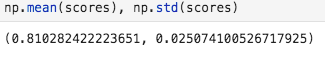

**1_2 расчет baseline + новая выборка для cat_71 + 84**

In [ ]:
%%time
clf_1_4 = LinearSVC(max_iter=400, random_state=12345)
scores_1_4 = cross_val_score(clf_1_4, X_train_extend_ROS, y_train_extend_ROS, cv=3, scoring='f1_weighted')

In [ ]:
np.mean(scores_1_4)

оригинальный + 71 + 84  cv=8
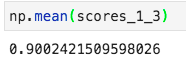

огигинальный + 71  cv=8
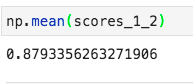

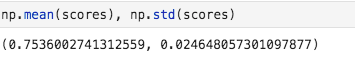

In [201]:
clf_1_3.fit(X_train_extend, y_train_extend)

LinearSVC(class_weight='balanced', max_iter=400, random_state=12345)

## подготовка данных для загрузки на сайт

In [207]:
tfidf = tfidf_ext
clf = clf_1_3

In [208]:
import pickle

pickle.dump(tfidf, open('t1_sub/tfidf', 'wb'))
pickle.dump(clf, open('t1_sub/clf_task1', 'wb'))

In [209]:
!ls -lh t1_sub

total 68344
-rw-r--r--@ 1 romanfomin  staff    30M Feb 15 14:18 clf_task1
-rw-r--r--@ 1 romanfomin  staff   372B Jan 24 11:54 script.py
-rw-r--r--@ 1 romanfomin  staff   1.3M Feb 15 14:18 tfidf


In [210]:
import zipfile 
compression = zipfile.ZIP_DEFLATED

debutants = 't1_sub/submission.zip'

with zipfile.ZipFile(debutants, 'w') as zipObj:
    for filename in ['clf_task1', 'tfidf', 'script.py']:
        zipObj.write(
            f't1_sub/{filename}', 
            arcname=filename, 
            compress_type=compression
        )
    print(zipObj.namelist())



['clf_task1', 'tfidf', 'script.py']


In [211]:
!ls -lh {debutants}

-rw-r--r--  1 romanfomin  staff   6.6M Feb 15 14:18 t1_sub/submission.zip
